In [1]:
import sys
if './' not in sys.path:
	sys.path.append('./')
from utils.share import *
import utils.config as config

import cv2
import einops
import gradio as gr
import numpy as np

import torch
from pytorch_lightning import seed_everything

from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from annotator.mlsd import MLSDdetector
from annotator.hed import HEDdetector
from annotator.sketch import SketchDetector
from annotator.openpose import OpenposeDetector
from annotator.midas import MidasDetector
from annotator.uniformer import UniformerDetector
from annotator.content import ContentDetector

from models.util import create_model, load_state_dict
from models.ddim_hacked import DDIMSampler


apply_canny = CannyDetector()
apply_mlsd = MLSDdetector()
apply_hed = HEDdetector()
apply_sketch = SketchDetector()
apply_openpose = OpenposeDetector()
apply_midas = MidasDetector()
apply_seg = UniformerDetector()
apply_content = ContentDetector()


model = create_model('./configs/uni_v15.yaml').cpu()
model.load_state_dict(load_state_dict('./ckpt/uni.ckpt', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)


/data/maryam.sana/anaconda3/envs/unicontrol/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.
Enabled sliced_attention.
cuda
cuda
Use Checkpoint: False
Checkpoint Number: [0, 0, 0, 0]
Use global window for all blocks in stage3
load checkpoint from local path: /data/maryam.sana/Uni-ControlNet/annotator/ckpts/upernet_global_small.pth
No module 'xformers'. Proceeding without it.
UniControlNet: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./configs/uni_v15.yaml]
Loaded state_dict from [./ckpt/uni.ckpt]


In [2]:
default_num_samples = 4
default_image_resolution = 512
default_strength = 1.0
default_global_strength = 1.0
default_low_threshold = 100
default_high_threshold = 200
default_value_threshold = 0.1
default_distance_threshold = 0.1
default_alpha = 6.2
default_ddim_steps = 50
default_scale = 7.5
default_seed = 42
default_eta = 0.0
default_a_prompt = 'best quality, extremely detailed'
default_n_prompt = ('longbody, lowres, bad anatomy, bad hands, missing fingers, '
                    'extra digit, fewer digits, cropped, worst quality, low quality')

def process(
    canny_image=None, mlsd_image=None, hed_image=None, sketch_image=None, openpose_image=None, 
    midas_image=None, seg_image=None, content_image=None, prompt="", 
    a_prompt=default_a_prompt, n_prompt=default_n_prompt, num_samples=default_num_samples, 
    image_resolution=default_image_resolution, ddim_steps=default_ddim_steps, 
    strength=default_strength, scale=default_scale, seed=default_seed, eta=default_eta, 
    low_threshold=default_low_threshold, high_threshold=default_high_threshold, 
    value_threshold=default_value_threshold, distance_threshold=default_distance_threshold, 
    alpha=default_alpha, global_strength=default_global_strength):
    
    seed_everything(seed)

    if canny_image is not None:
        anchor_image = canny_image
    elif mlsd_image is not None:
        anchor_image = mlsd_image
    elif hed_image is not None:
        anchor_image = hed_image
    elif sketch_image is not None:
        anchor_image = sketch_image
    elif openpose_image is not None:
        anchor_image = openpose_image
    elif midas_image is not None:
        anchor_image = midas_image
    elif seg_image is not None:
        anchor_image = seg_image
    elif content_image is not None:
        anchor_image = content_image
    else:
        anchor_image = np.zeros((image_resolution, image_resolution, 3)).astype(np.uint8)
    H, W, C = resize_image(HWC3(anchor_image), image_resolution).shape
    print('in process')
    with torch.no_grad():
        if canny_image is not None:
            canny_image = cv2.resize(canny_image, (W, H))
            canny_detected_map = HWC3(apply_canny(HWC3(canny_image), low_threshold, high_threshold))
        else:
            canny_detected_map = np.zeros((H, W, C)).astype(np.uint8)
        if mlsd_image is not None:
            mlsd_image = cv2.resize(mlsd_image, (W, H))
            mlsd_detected_map = HWC3(apply_mlsd(HWC3(mlsd_image), value_threshold, distance_threshold))
        else:
            mlsd_detected_map = np.zeros((H, W, C)).astype(np.uint8)
        if hed_image is not None:
            hed_image = cv2.resize(hed_image, (W, H))
            hed_detected_map = HWC3(apply_hed(HWC3(hed_image)))
        else:
            hed_detected_map = np.zeros((H, W, C)).astype(np.uint8)
        if sketch_image is not None:
            sketch_image = cv2.resize(sketch_image, (W, H))
            sketch_detected_map = HWC3(apply_sketch(HWC3(sketch_image)))            
        else:
            sketch_detected_map = np.zeros((H, W, C)).astype(np.uint8)
        if openpose_image is not None:
            openpose_image = cv2.resize(openpose_image, (W, H))
            openpose_detected_map, _ = apply_openpose(HWC3(openpose_image), False)
            openpose_detected_map = HWC3(openpose_detected_map)
        else:
            openpose_detected_map = np.zeros((H, W, C)).astype(np.uint8)
        if midas_image is not None:
            midas_image = cv2.resize(midas_image, (W, H))
            midas_detected_map = HWC3(apply_midas(HWC3(midas_image), alpha))
        else:
            midas_detected_map = np.zeros((H, W, C)).astype(np.uint8)
        if seg_image is not None:
            seg_image = cv2.resize(seg_image, (W, H))
            seg_detected_map, _ = apply_seg(HWC3(seg_image))
            seg_detected_map = HWC3(seg_detected_map)
        else:
            seg_detected_map = np.zeros((H, W, C)).astype(np.uint8)
        if content_image is not None:
            content_emb = apply_content(content_image)
        else:
            content_emb = np.zeros((768))

        detected_maps_list = [canny_detected_map, 
                              mlsd_detected_map, 
                              hed_detected_map,
                              sketch_detected_map,
                              openpose_detected_map,
                              midas_detected_map,
                              seg_detected_map                          
                              ]
        detected_maps = np.concatenate(detected_maps_list, axis=2)

        local_control = torch.from_numpy(detected_maps.copy()).float().cuda() / 255.0
        local_control = torch.stack([local_control for _ in range(num_samples)], dim=0)
        local_control = einops.rearrange(local_control, 'b h w c -> b c h w').clone()
        global_control = torch.from_numpy(content_emb.copy()).float().cuda().clone()
        global_control = torch.stack([global_control for _ in range(num_samples)], dim=0)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        uc_local_control = local_control
        uc_global_control = torch.zeros_like(global_control)
        cond = {"local_control": [local_control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)], 'global_control': [global_control]}
        un_cond = {"local_control": [uc_local_control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)], 'global_control': [uc_global_control]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength] * 13
        samples, _ = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond, global_strength=global_strength)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
        results = [x_samples[i] for i in range(num_samples)]

    return [results, detected_maps_list]

In [3]:
from PIL import Image
import numpy as np

# Load the image
image_path = 'data/img00010.png'
image = Image.open(image_path)
np_image = np.array(image)
prompt = 'Jockey on a running horse'

In [4]:
seg_image = np_image
H, W, C = resize_image(HWC3(seg_image), 512).shape
seg_image = cv2.resize(seg_image, (W, H))
seg_detected_map, _ = apply_seg(HWC3(seg_image))
seg_detected_map = HWC3(seg_detected_map)

/data/maryam.sana/Uni-ControlNet/annotator/uniformer/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


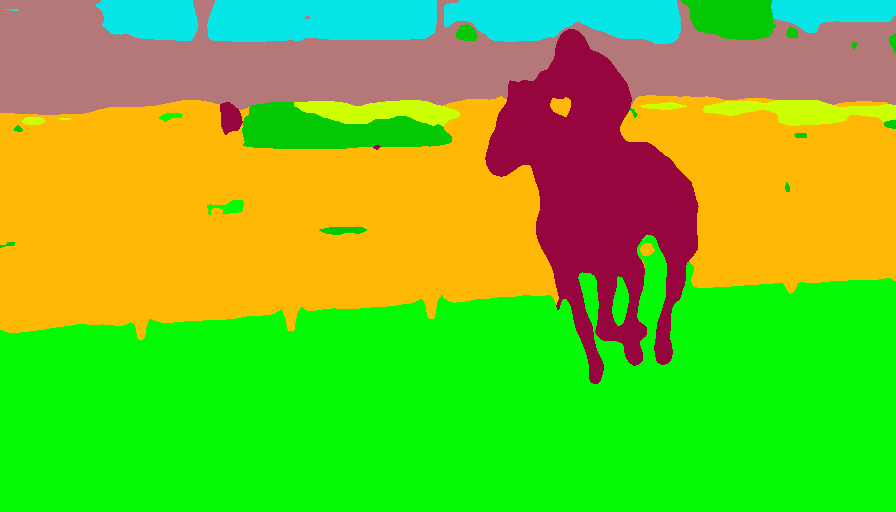

In [5]:
Image.fromarray(seg_detected_map)
# seg_detected_map

In [6]:
results = process(
    seg_image=np_image,
    prompt=prompt)

Global seed set to 42


in process
Data shape for DDIM sampling is (4, 4, 64, 112), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|████████████████████████████████████████████████████████████| 50/50 [01:28<00:00,  1.78s/it]


In [7]:
images_array = results[0]

# Convert each image to a PIL image
pil_images = [Image.fromarray(image) for image in images_array]

# Display the first image as a check (optional)
# pil_images[0]

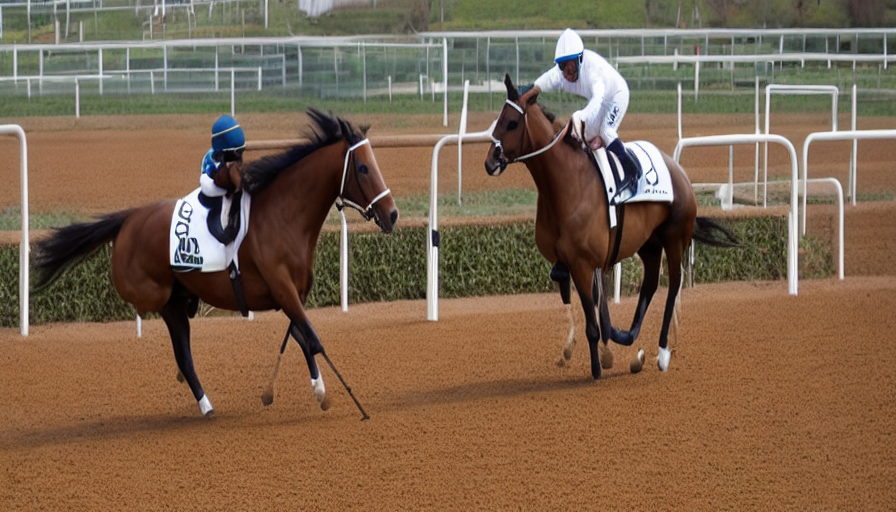

In [13]:
pil_images[0]

In [9]:
image_path = 'data/j_017.png'
image = cv2.imread(image_path)
seg_map = np.array(image)
prompt = 'Jockey on a running horse'

In [10]:
# cv2.resize(seg_map, (W, H)).shape

In [11]:
num_samples = 4
image_resolution = 512
strength = 1.0
global_strength = 1.0
low_threshold = 100
high_threshold = 200
value_threshold = 0.1
distance_threshold = 0.1
alpha = 6.2
ddim_steps = 50
scale = 7.5
seed = 42
eta = 0.0
a_prompt = 'best quality, extremely detailed'
n_prompt = ('longbody, lowres, bad anatomy, bad hands, missing fingers, '
            'extra digit, fewer digits, cropped, worst quality, low quality')
anchor_image = seg_map
H, W, C = resize_image(HWC3(anchor_image), image_resolution).shape
print('in process')
with torch.no_grad():
    canny_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    mlsd_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    hed_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    sketch_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    openpose_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    midas_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    seg_map = cv2.resize(seg_map, (W, H))
    seg_detected_map = HWC3(seg_map)
    content_emb = np.zeros((768))

    detected_maps_list = [canny_detected_map, 
                          mlsd_detected_map, 
                          hed_detected_map,
                          sketch_detected_map,
                          openpose_detected_map,
                          midas_detected_map,
                          seg_detected_map                          
                          ]
    detected_maps = np.concatenate(detected_maps_list, axis=2)

    local_control = torch.from_numpy(detected_maps.copy()).float().cuda() / 255.0
    local_control = torch.stack([local_control for _ in range(num_samples)], dim=0)
    local_control = einops.rearrange(local_control, 'b h w c -> b c h w').clone()
    global_control = torch.from_numpy(content_emb.copy()).float().cuda().clone()
    global_control = torch.stack([global_control for _ in range(num_samples)], dim=0)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    uc_local_control = local_control
    uc_global_control = torch.zeros_like(global_control)
    cond = {"local_control": [local_control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)], 'global_control': [global_control]}
    un_cond = {"local_control": [uc_local_control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)], 'global_control': [uc_global_control]}
    shape = (4, H // 8, W // 8)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=True)

    model.control_scales = [strength] * 13
    samples, _ = ddim_sampler.sample(ddim_steps, num_samples,
                                                 shape, cond, verbose=False, eta=eta,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=un_cond, global_strength=global_strength)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    x_samples = model.decode_first_stage(samples)
    x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
    results = [x_samples[i] for i in range(num_samples)]

in process
Data shape for DDIM sampling is (4, 4, 64, 112), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler:  50%|██████████████████████████████                              | 25/50 [00:46<00:46,  1.84s/it]


KeyboardInterrupt: 

In [ ]:
output_images = [Image.fromarray(image) for image in results]

In [ ]:
output_images[1]